#Download the dataset#

In [1]:
!pip install -q gdown

import gdown
import zipfile
import os


file_id = "1AgFlGYaEg4YWtmYzkN97O7jhKFPsKltD"
destination = "data.zip"

gdown.download(f"https://drive.google.com/uc?id={file_id}", destination, quiet=False)


with zipfile.ZipFile(destination, 'r') as zip_ref:
    zip_ref.extractall('./')

os.remove(destination)

Downloading...
From: https://drive.google.com/uc?id=1AgFlGYaEg4YWtmYzkN97O7jhKFPsKltD
To: /content/data.zip
100%|██████████| 23.2M/23.2M [00:00<00:00, 93.5MB/s]


Import Libraries

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from tqdm import tqdm

import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Feature Engineering Techniques#

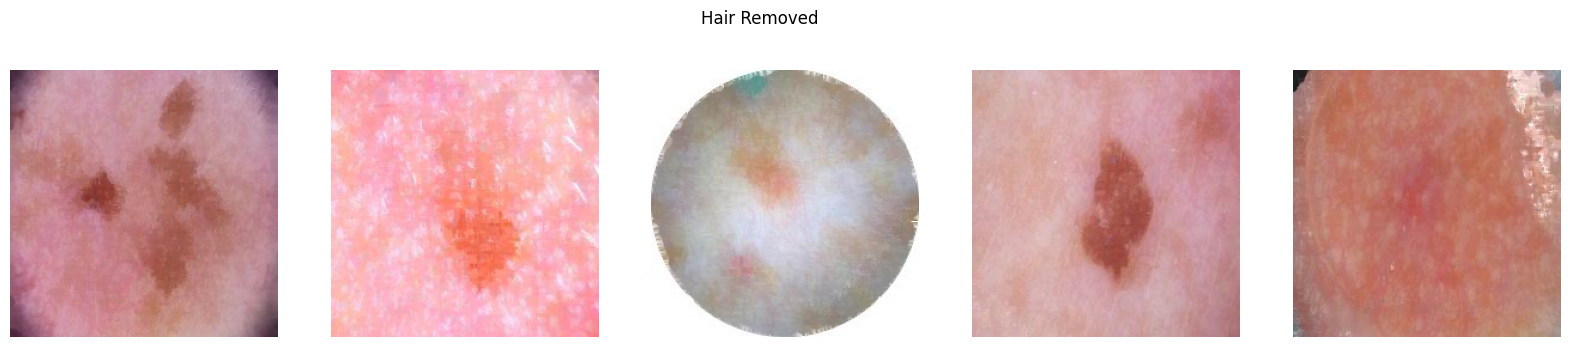

In [3]:
def remove_hair(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kernel = cv2.getStructuringElement(1, (17, 17))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    _, mask = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    result = cv2.inpaint(img, cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY), 1, cv2.INPAINT_TELEA)
    return result

# Display 5 images
sample_paths = glob("/content/ISIC Dataset/Train/Benign/*.jpg")[:5]
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, path in enumerate(sample_paths):
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    no_hair = remove_hair(img)
    axs[i].imshow(no_hair)
    axs[i].axis('off')
plt.suptitle("Hair Removed")
plt.show()


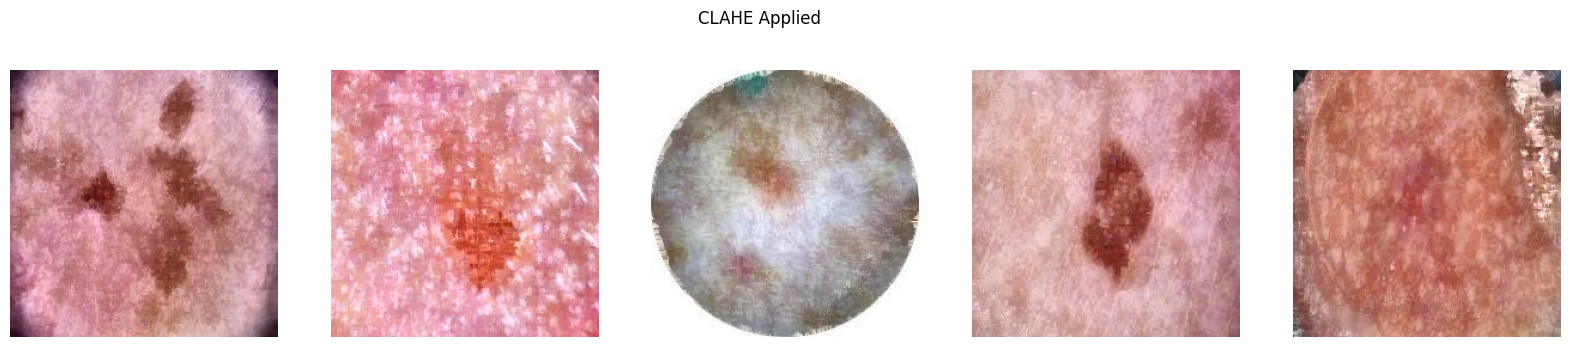

In [4]:
def apply_clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return final

# Display 5 images
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, path in enumerate(sample_paths):
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    no_hair = remove_hair(img)
    eq = apply_clahe(no_hair)
    axs[i].imshow(eq)
    axs[i].axis('off')
plt.suptitle("CLAHE Applied")
plt.show()


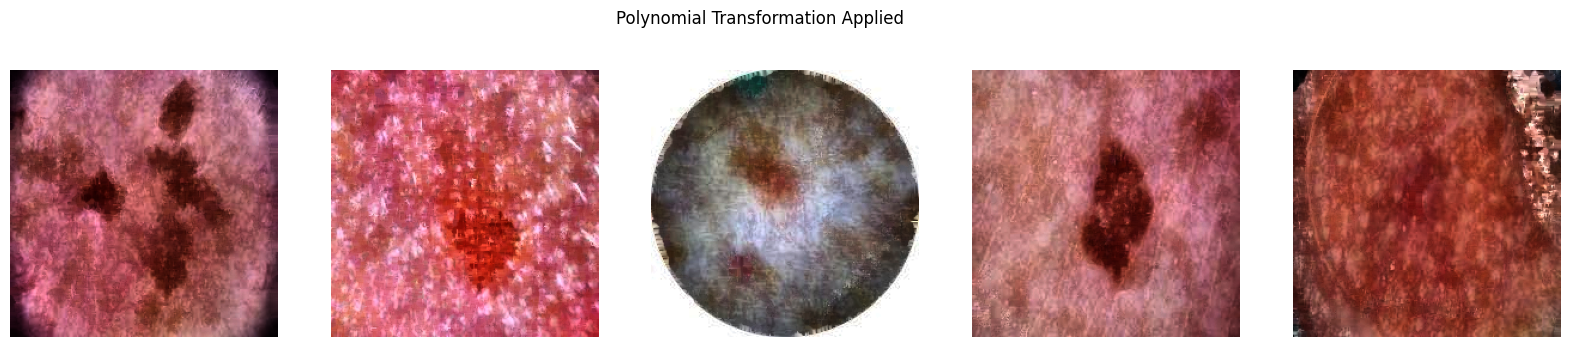

In [5]:
def poly_transform(img):
    img = img.astype(np.float32) / 255.0
    poly_img = np.power(img, 2.0)
    poly_img = (poly_img * 255).astype(np.uint8)
    return poly_img

# Display 5 images
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, path in enumerate(sample_paths):
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    processed = poly_transform(apply_clahe(remove_hair(img)))
    axs[i].imshow(processed)
    axs[i].axis('off')
plt.suptitle("Polynomial Transformation Applied")
plt.show()


#Preprocess and Transform Dataset#

In [6]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
from torchvision.io import read_image

class CustomSkinDataset(Dataset):
    def __init__(self, root_dir, transform=None, augment=False):
        self.dataset = ImageFolder(root_dir)
        self.transform = transform
        self.augment = augment

    def __getitem__(self, idx):
        img_path, label = self.dataset.imgs[idx]
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        img = remove_hair(img)
        img = apply_clahe(img)
        img = poly_transform(img)
        img = Image.fromarray(img)
        if self.augment:
            img = self.transform(img)
        else:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.dataset)

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.ToTensor()
])



Load Dataset

In [7]:
# Load datasets
train_data = CustomSkinDataset("/content/ISIC Dataset/Train", transform=train_transform, augment=True)
val_data = CustomSkinDataset("/content/ISIC Dataset/Val", transform=test_transform)
test_data = CustomSkinDataset("/content/ISIC Dataset/Test", transform=test_transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)


#ResNet50

In [8]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 61.6MB/s]


Training

In [9]:
best_acc = 0
for epoch in range(15):
    model.train()
    train_loss, correct, total = 0, 0, 0
    for imgs, labels in tqdm(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100. * correct / total
    print(f"Epoch {epoch+1}, Train Acc: {train_acc:.2f}%, Loss: {train_loss/len(train_loader):.4f}")

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_acc = 100. * correct / total
    print(f"Validation Acc: {val_acc:.2f}%")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print("Best Model Saved")


100%|██████████| 84/84 [01:08<00:00,  1.23it/s]


Epoch 1, Train Acc: 80.99%, Loss: 0.4044


100%|██████████| 21/21 [00:09<00:00,  2.31it/s]


Validation Acc: 83.73%
Best Model Saved


100%|██████████| 84/84 [00:55<00:00,  1.51it/s]


Epoch 2, Train Acc: 87.86%, Loss: 0.2753


100%|██████████| 21/21 [00:09<00:00,  2.29it/s]


Validation Acc: 84.19%
Best Model Saved


100%|██████████| 84/84 [00:57<00:00,  1.45it/s]


Epoch 3, Train Acc: 90.92%, Loss: 0.2028


100%|██████████| 21/21 [00:09<00:00,  2.11it/s]


Validation Acc: 84.34%
Best Model Saved


100%|██████████| 84/84 [00:55<00:00,  1.51it/s]


Epoch 4, Train Acc: 92.34%, Loss: 0.1909


100%|██████████| 21/21 [00:09<00:00,  2.32it/s]


Validation Acc: 83.73%


100%|██████████| 84/84 [00:55<00:00,  1.52it/s]


Epoch 5, Train Acc: 94.32%, Loss: 0.1536


100%|██████████| 21/21 [00:08<00:00,  2.36it/s]


Validation Acc: 79.67%


100%|██████████| 84/84 [00:55<00:00,  1.52it/s]


Epoch 6, Train Acc: 95.44%, Loss: 0.1137


100%|██████████| 21/21 [00:08<00:00,  2.48it/s]


Validation Acc: 83.58%


100%|██████████| 84/84 [00:55<00:00,  1.53it/s]


Epoch 7, Train Acc: 95.55%, Loss: 0.1185


100%|██████████| 21/21 [00:08<00:00,  2.34it/s]


Validation Acc: 87.65%
Best Model Saved


100%|██████████| 84/84 [00:54<00:00,  1.54it/s]


Epoch 8, Train Acc: 96.60%, Loss: 0.0877


100%|██████████| 21/21 [00:08<00:00,  2.34it/s]


Validation Acc: 85.09%


100%|██████████| 84/84 [00:54<00:00,  1.54it/s]


Epoch 9, Train Acc: 96.86%, Loss: 0.0922


100%|██████████| 21/21 [00:08<00:00,  2.39it/s]


Validation Acc: 85.99%


100%|██████████| 84/84 [00:54<00:00,  1.53it/s]


Epoch 10, Train Acc: 96.19%, Loss: 0.0966


100%|██████████| 21/21 [00:08<00:00,  2.53it/s]


Validation Acc: 88.55%
Best Model Saved


100%|██████████| 84/84 [00:54<00:00,  1.53it/s]


Epoch 11, Train Acc: 96.97%, Loss: 0.0813


100%|██████████| 21/21 [00:09<00:00,  2.33it/s]


Validation Acc: 84.64%


100%|██████████| 84/84 [00:54<00:00,  1.54it/s]


Epoch 12, Train Acc: 96.94%, Loss: 0.0795


100%|██████████| 21/21 [00:08<00:00,  2.35it/s]


Validation Acc: 86.45%


100%|██████████| 84/84 [00:54<00:00,  1.55it/s]


Epoch 13, Train Acc: 97.83%, Loss: 0.0653


100%|██████████| 21/21 [00:08<00:00,  2.35it/s]


Validation Acc: 86.45%


100%|██████████| 84/84 [00:54<00:00,  1.53it/s]


Epoch 14, Train Acc: 97.39%, Loss: 0.0773


100%|██████████| 21/21 [00:08<00:00,  2.52it/s]


Validation Acc: 86.30%


100%|██████████| 84/84 [00:54<00:00,  1.53it/s]


Epoch 15, Train Acc: 98.47%, Loss: 0.0421


100%|██████████| 21/21 [00:08<00:00,  2.36it/s]

Validation Acc: 84.34%


Validation

In [10]:
# Load best model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

y_true, y_pred = [], []
y_scores = []

with torch.no_grad():
    for imgs, labels in tqdm(val_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)  # logits or probabilities
        probs = torch.softmax(outputs, dim=1)[:, 1]  # get score for class 1 (Malignant)

        _, preds = outputs.max(1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_scores.extend(probs.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=["Benign", "Malignant"]))


100%|██████████| 21/21 [00:08<00:00,  2.52it/s]

              precision    recall  f1-score   support

      Benign       0.91      0.86      0.88       339
   Malignant       0.86      0.92      0.89       325

    accuracy                           0.89       664
   macro avg       0.89      0.89      0.89       664
weighted avg       0.89      0.89      0.89       664



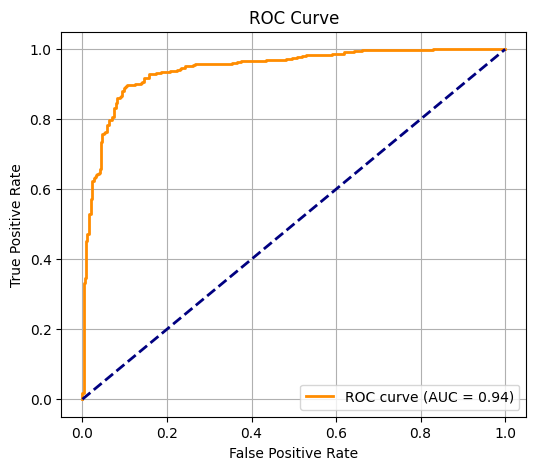

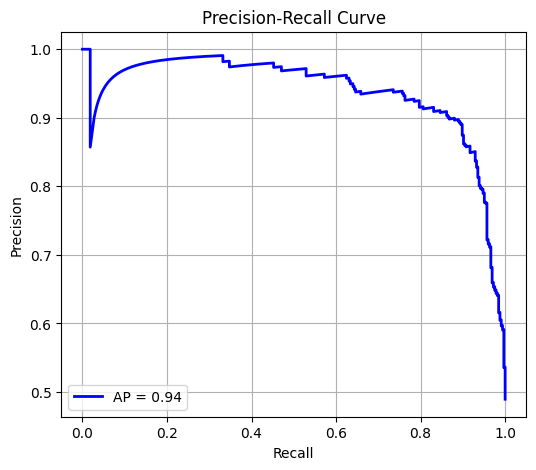

In [11]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_scores)
ap_score = average_precision_score(y_true, y_scores)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, color='blue', lw=2, label=f'AP = {ap_score:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


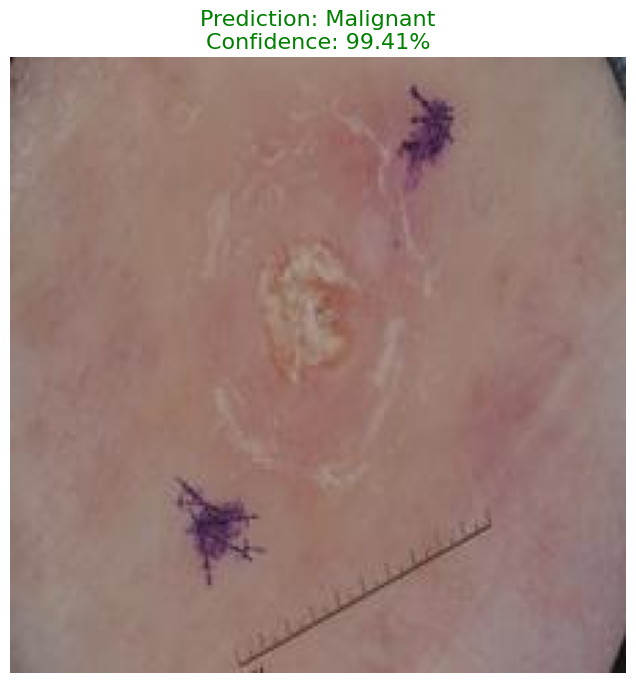

In [14]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from glob import glob
import random


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_names = ["Benign", "Malignant"]



resnet = models.resnet50(pretrained=False)
resnet.fc = nn.Linear(resnet.fc.in_features, 2)
resnet.load_state_dict(torch.load("best_model.pth", map_location=device))
resnet = resnet.to(device).eval()


all_test_paths = glob("/content/ISIC Dataset/Test/*/*.jpg")
sample_path = random.choice(all_test_paths)


def preprocess_image(path):
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    img = remove_hair(img)
    img = apply_clahe(img)
    img = poly_transform(img)
    img = Image.fromarray(img)
    img = test_transform(img)
    return img.unsqueeze(0)


img_tensor = preprocess_image(sample_path).to(device)

with torch.no_grad():
    outputs = resnet(img_tensor)
    probabilities = torch.softmax(outputs, dim=1)
    confidence, predicted_class = torch.max(probabilities, 1)

predicted_label = class_names[predicted_class.item()]
confidence_score = confidence.item()


img_disp = cv2.cvtColor(cv2.imread(sample_path), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 8))
plt.imshow(img_disp)
plt.axis('off')
plt.title(f"Prediction: {predicted_label}\nConfidence: {confidence_score:.2%}", fontsize=16, color='green')
plt.show()

